In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd drive/MyDrive/Github/ml-blog

/content/drive/MyDrive/Github/ml-blog


In [ ]:
# !pip install xlrd==1.2.0
# !pip install matplotlib==3.5.3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
filename = 'taiwan-credit-col-transform-FULL.csv'

In [ ]:
DATA = os.path.relpath('/content/drive/MyDrive/Github/ml-blog/credit/data/' + filename)

In [ ]:
df = pd.read_csv(DATA, header='infer', index_col=0)
df.head()

,category__SEX_1,category__SEX_2,category__EDUCATION_0,category__EDUCATION_1,category__EDUCATION_2,category__EDUCATION_3,category__EDUCATION_4,category__EDUCATION_5,category__EDUCATION_6,category__MARRIAGE_0,...,nums__BILL_AMT4,nums__BILL_AMT5,nums__BILL_AMT6,nums__PAY_AMT1,nums__PAY_AMT2,nums__PAY_AMT3,nums__PAY_AMT4,nums__PAY_AMT5,nums__PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = df.iloc[:, :91]
Y = df.iloc[:, 91]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
rf_clf_baseline = RandomForestClassifier(n_estimators=50, max_depth=6, max_features='sqrt', random_state=42)

In [ ]:
scores_base = cross_val_score(rf_clf_baseline, X_train, y_train, cv=5)

In [ ]:
print(round(scores_base.mean() * 100, 3), '%')

81.038 %


## Receiver Operating Characteristic Analysis

* The dataset's classes are **imbalanced**, so `accuracy_score` will not be the optimal way to evaluate the model's performance.

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
y_probas = rf_clf_baseline.fit(X_train, y_train).predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 1 for 'Default'.

In [ ]:
y_test_np = y_test.to_numpy()

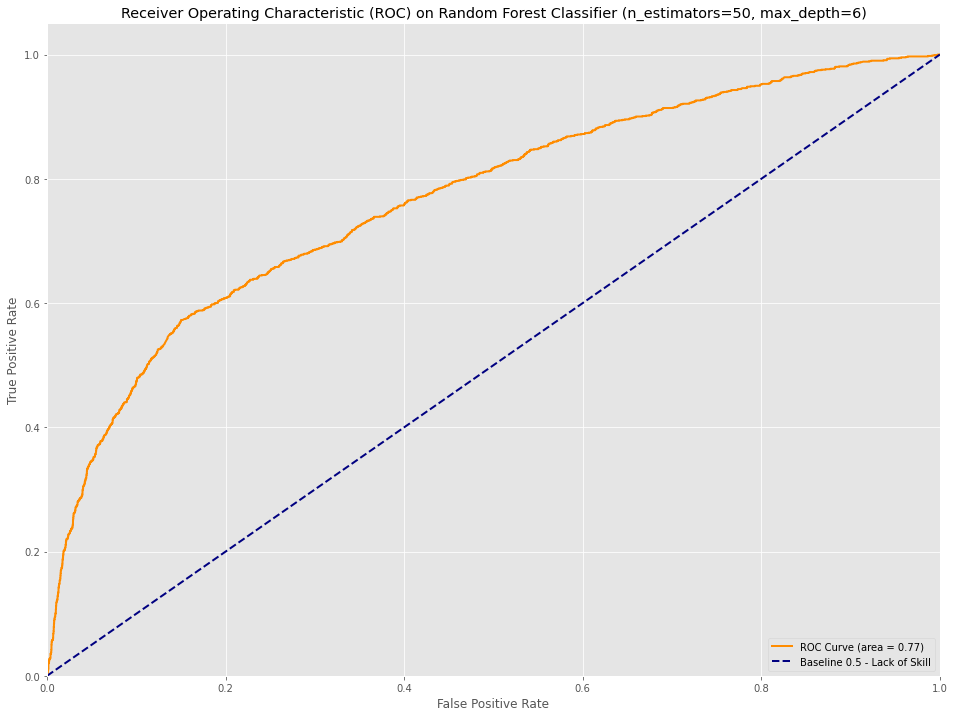

In [ ]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test_np, y_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on Random Forest Classifier (n_estimators=50, max_depth=6)')
plt.legend(loc='lower right')
plt.savefig('./credit/EDA/randf-bin-roc-auc-plot.png')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

In [64]:
params = {'n_estimators': [5, 10, 25, 50, 100, 150],
          'criterion': ('gini', 'entropy'),
          'max_features': ['sqrt', 'log2', 80, 90],
          'max_depth': [2, 4, 6]}

In [65]:
rf = RandomForestClassifier()

gs_clf = GridSearchCV(rf, params)

In [66]:
gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 4, 6],
                         'max_features': ['sqrt', 'log2', 80, 90],
                         'n_estimators': [5, 10, 25, 50, 100, 150]})

In [67]:
gs_clf.best_estimator_

RandomForestClassifier(max_depth=6, max_features=90, n_estimators=25)

In [68]:
grid_rf_results = pd.DataFrame(gs_clf.cv_results_)

In [79]:
grid_rf_results.iloc[15,:]

mean_fit_time                                                  2.169917
std_fit_time                                                   0.031932
mean_score_time                                                0.021239
std_score_time                                                 0.001111
param_criterion                                                    gini
param_max_depth                                                       2
param_max_features                                                   80
param_n_estimators                                                   50
params                {'criterion': 'gini', 'max_depth': 2, 'max_fea...
split0_test_score                                              0.815417
split1_test_score                                                0.8175
split2_test_score                                                  0.81
split3_test_score                                              0.810208
split4_test_score                                              0

In [80]:
rf_clf_best_gs = RandomForestClassifier(n_estimators=25, max_depth=6, max_features=90, random_state=42)

In [81]:
scores_base_2 = cross_val_score(rf_clf_best_gs, X_train, y_train, cv=5)

In [82]:
print(round(scores_base_2.mean() * 100, 3), '%')

81.958 %


In [83]:
y_probas_best_est = rf_clf_best_gs.fit(X_train, y_train).predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 1 for 'Default'.

In [84]:
y_pred_rf1 = rf_clf_best_gs.predict(X_test)

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4687
           1       0.69      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [87]:
print(confusion_matrix(y_test, y_pred_rf1))

[[4485  202]
 [ 871  442]]


In [89]:
title = 'Confusion Matrix for Random Forest Model, (n_estimators=25, max_depth=6, max_features=90)'

Confusion Matrix for Random Forest Model, (n_estimators=25, max_depth=6, max_features=90)
[[0.95690207 0.04309793]
 [0.66336634 0.33663366]]


<Figure size 1440x1440 with 0 Axes>

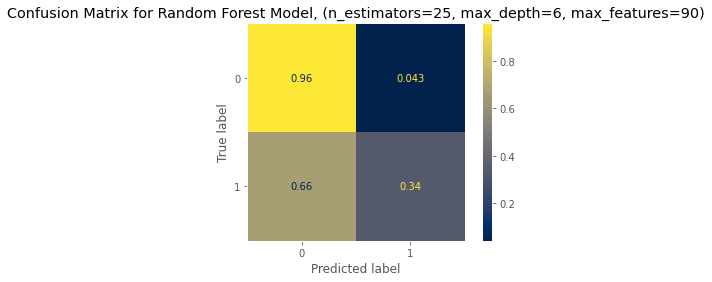

In [108]:
plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf_best_gs,
    X_test,
    y_test,
    display_labels=['0','1'],
    cmap=plt.cm.cividis,
    normalize='true'
)

disp.ax_.set_title(title)

disp.ax_.grid(False)

print(title)
print(disp.confusion_matrix)
plt.savefig('RF_confusion_matrix_best_gs.png')
plt.show()

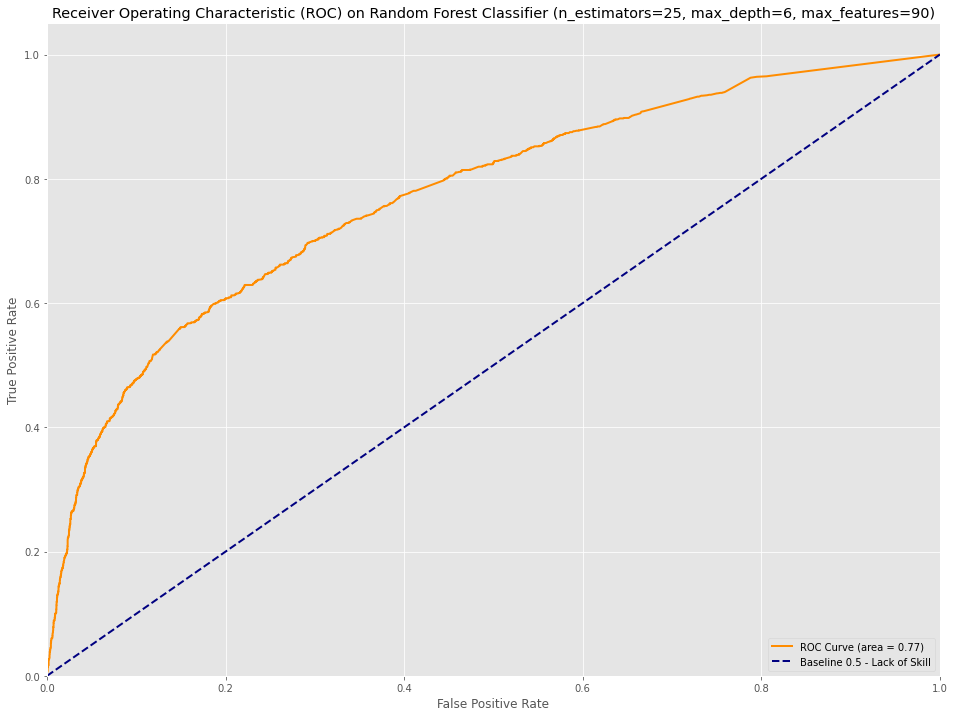

In [109]:
truePR_gs = dict()
falsePR_gs = dict()
roc_auc_gs = dict()


falsePR_gs, truePR_gs, _ = roc_curve(y_test_np, y_probas_best_est)
roc_auc_gs = auc(falsePR_gs, truePR_gs)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR_gs,
    truePR_gs,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc_gs,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on Random Forest Classifier (n_estimators=25, max_depth=6, max_features=90)')
plt.legend(loc='lower right')
plt.savefig('./credit/EDA/randf-bin-roc-auc-plot_best_est.png')
plt.show()
